In [9]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

# Для чтения изображений с диска
from torchvision import io # input/output
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os

In [10]:
transform = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
        T.RandomHorizontalFlip(),
        T.RandomPerspective(),
    ]
)

In [17]:
train_dataset = torchvision.datasets.ImageFolder(
    '/home/vlad/нейронки/images/TRAIN',
    transform=transform
)
valid_dataset = torchvision.datasets.ImageFolder(
    '/home/vlad/нейронки/images/TEST',
    transform=transform
)


In [18]:
train_dataset


Dataset ImageFolder
    Number of datapoints: 9957
    Root location: /home/vlad/нейронки/images/TRAIN
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [19]:

train_dataset.class_to_idx     


{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

In [20]:
idx2class= {j: i for i, j in train_dataset.class_to_idx.items()}
idx2class

{0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}

In [23]:
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [24]:
print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(valid_dataset)}")

Размер обучающей выборки: 9957
Размер валидационной выборки: 2487


In [25]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


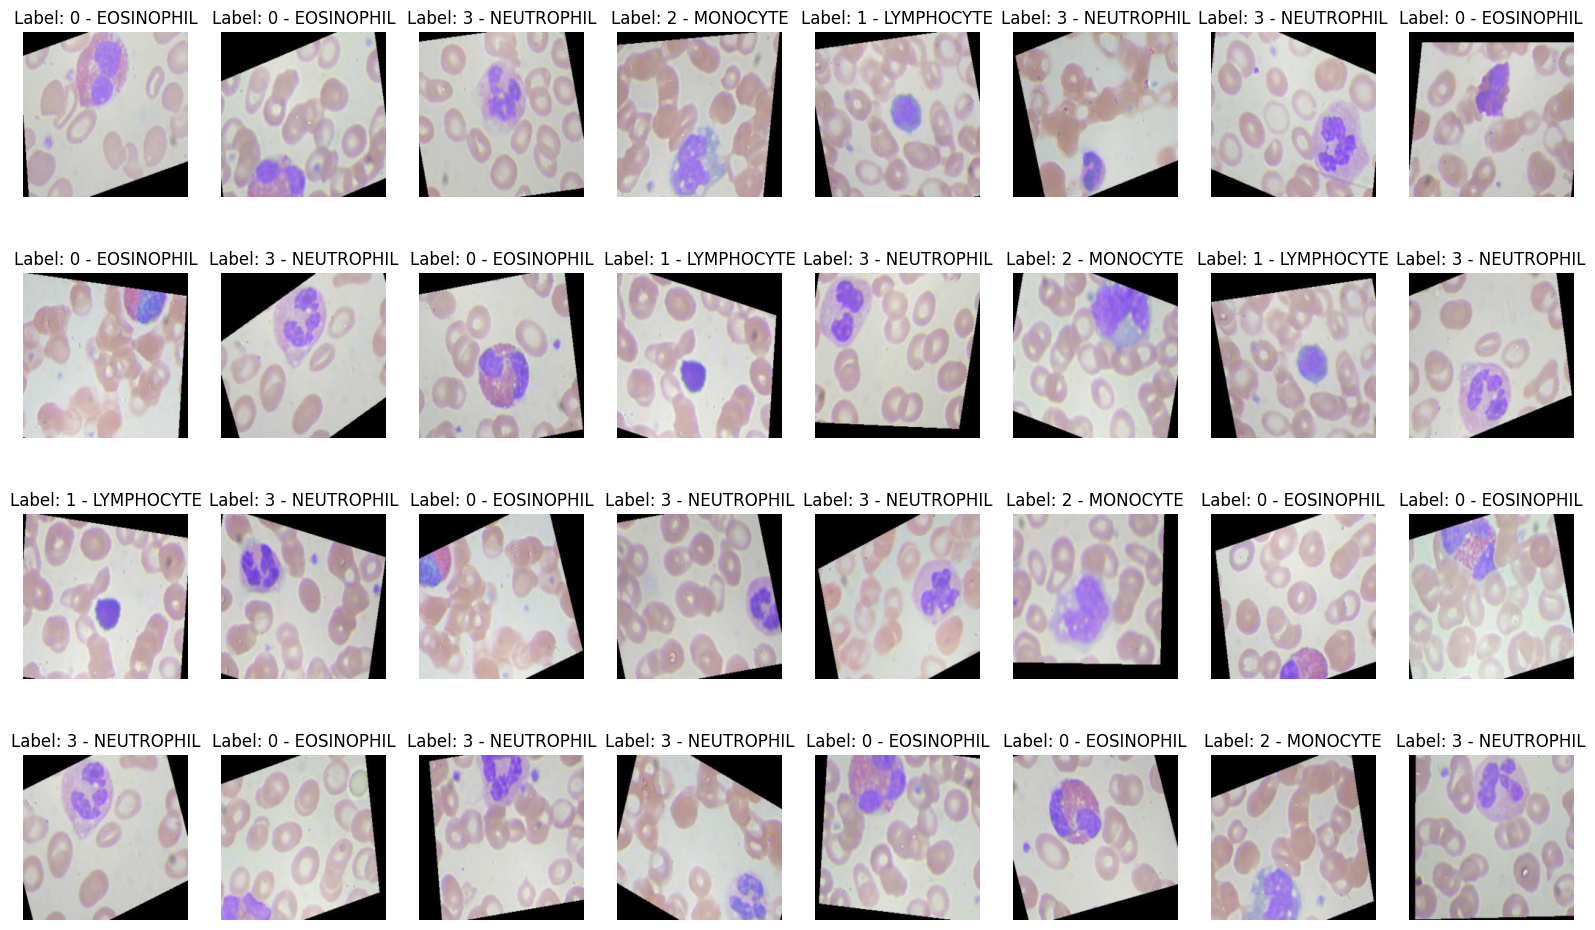

In [28]:
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten()
test_batch = next(iter(valid_loader))
test_samples, test_targets = test_batch

for i, plot in enumerate(ax):
    label_index = test_targets[i].item()
    plot.set_title(f'Label: {label_index} - {valid_loader.dataset.classes[label_index]}')

    # Проверяем количество каналов
    if test_samples[i].shape[0] == 3:  # Если 3 канала (RGB)
        img = test_samples[i].permute(1, 2, 0)  # Транспонируем в (высота, ширина, каналы)
        #img = (img + 1) / 2  # Переводим в диапазон [0, 1]
        #img = img * 255      # Переводим в диапазон [0, 255]
        #img = img.int()   
    elif test_samples[i].shape[0] == 1:  # Если 1 канал (оттенки серого)
        img = test_samples[i][0, :, :]  # Оставляем как есть
    else:
        raise ValueError("Неизвестное количество каналов")

    plot.imshow(img.cpu())  # Используем imshow() для цветных изображений
    plot.axis('off')

plt.show()

In [31]:
def fit(
    model: torch.nn.Module,
    n_epochs: int,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    valid_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    device: torch.device
) -> tuple[list, ...]:
    """
    Function to fit model.
    Returns:
        train_losses: list of train losses per epoch
        valid_losses: list of valid losses per epoch
        train_acc: list of train accuracy per epoch
        valid_acc: list of valid accuracy per epoch
    """
    train_losses = []
    valid_losses = []
    train_acc = []
    valid_acc = []

    for epoch in range(n_epochs):
        # Обучающий шаг
        model.train()  # Режим обучения
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            # Перемещаем данные на устройство
            images = images.to(device)
            labels = labels.to(device)

            # Преобразуем метки в long, если они не являются такими
            if labels.dtype != torch.int64:
                labels = labels.long()

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            # Собираем статистику
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Сохраняем среднюю потерю и точность на тренировке
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(correct_train / total_train)

        # Валидационный шаг
        model.eval()  # Режим оценки
        running_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():  # Отключаем вычисление градиентов
            for images, labels in valid_loader:
                # Перемещаем данные на устройство
                images = images.to(device)
                labels = labels.to(device)

                # Преобразуем метки в long, если они не являются такими
                if labels.dtype != torch.int64:
                    labels = labels.long()

                # Прямой проход
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Собираем статистику
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        # Сохраняем среднюю потерю и точность на валидации
        valid_losses.append(running_loss / len(valid_loader))
        valid_acc.append(correct_valid / total_valid)

        # Выводим прогресс
        print(f"Epoch [{epoch + 1}/{n_epochs}], "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, "
              f"Valid Loss: {valid_losses[-1]:.4f}, Valid Acc: {valid_acc[-1]:.4f}")

    return train_losses, valid_losses, train_acc, valid_acc

In [32]:
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)


In [33]:
tu.get_model_summary(model.to(device), test_samples[1].unsqueeze(0).to(device))

Layer                                       Kernel             Output          Params           FLOPs
0_conv1                                   [3, 64, 7, 7]   [1, 64, 112, 112]       9,408   118,013,952
1_bn1                                              [64]   [1, 64, 112, 112]         128     3,211,264
2_relu                                                -   [1, 64, 112, 112]           0             0
3_maxpool                                             -     [1, 64, 56, 56]           0             0
4_layer1.0.Conv2d_conv1                  [64, 64, 3, 3]     [1, 64, 56, 56]      36,864   115,605,504
5_layer1.0.BatchNorm2d_bn1                         [64]     [1, 64, 56, 56]         128       802,816
6_layer1.0.ReLU_relu                                  -     [1, 64, 56, 56]           0             0
7_layer1.0.Conv2d_conv2                  [64, 64, 3, 3]     [1, 64, 56, 56]      36,864   115,605,504
8_layer1.0.BatchNorm2d_bn2                         [64]     [1, 64, 56, 56]       

In [35]:
model.fc
model.fc = nn.Linear(512, 4)

In [37]:
for param in model.parameters():
    param.requires_grad = False

In [38]:
for i, param in enumerate(model.parameters()):
    print(i, param.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False


In [41]:
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

model.layer4[0].conv1.weight.requires_grad = True
model.layer4[0].bn1.weight.requires_grad = True
model.layer4[0].bn1.bias.requires_grad = True
model.layer4[0].conv2.weight.requires_grad = True
model.layer4[0].bn2.weight.requires_grad = True
model.layer4[0].bn2.bias.requires_grad = True
model.layer4[0].downsample[0].weight.requires_grad = True
model.layer4[0].downsample[1].weight.requires_grad = True
model.layer4[0].downsample[1].bias.requires_grad = True

model.layer4[1].conv1.weight.requires_grad = True
model.layer4[1].bn1.weight.requires_grad = True
model.layer4[1].bn1.bias.requires_grad = True
model.layer4[1].conv2.weight.requires_grad = True
model.layer4[1].bn2.weight.requires_grad = True
model.layer4[1].bn2.bias.requires_grad = True

In [42]:
model.to(device)
for i, params in model.named_parameters():
    print(f"{i}: {'True' if params.requires_grad else 'False'}")

conv1.weight: False
bn1.weight: False
bn1.bias: False
layer1.0.conv1.weight: False
layer1.0.bn1.weight: False
layer1.0.bn1.bias: False
layer1.0.conv2.weight: False
layer1.0.bn2.weight: False
layer1.0.bn2.bias: False
layer1.1.conv1.weight: False
layer1.1.bn1.weight: False
layer1.1.bn1.bias: False
layer1.1.conv2.weight: False
layer1.1.bn2.weight: False
layer1.1.bn2.bias: False
layer2.0.conv1.weight: False
layer2.0.bn1.weight: False
layer2.0.bn1.bias: False
layer2.0.conv2.weight: False
layer2.0.bn2.weight: False
layer2.0.bn2.bias: False
layer2.0.downsample.0.weight: False
layer2.0.downsample.1.weight: False
layer2.0.downsample.1.bias: False
layer2.1.conv1.weight: False
layer2.1.bn1.weight: False
layer2.1.bn1.bias: False
layer2.1.conv2.weight: False
layer2.1.bn2.weight: False
layer2.1.bn2.bias: False
layer3.0.conv1.weight: False
layer3.0.bn1.weight: False
layer3.0.bn1.bias: False
layer3.0.conv2.weight: False
layer3.0.bn2.weight: False
layer3.0.bn2.bias: False
layer3.0.downsample.0.weight: 

In [43]:
optima = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [44]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import datetime
start = datetime.datetime.now()
print('Время старта: ' + str(start))

# Перемещаем модель на устройство
model.to(device)

# Обучение модели с использованием функции fit
train_losses, valid_losses, train_acc, valid_acc = fit(
    model=model,
    n_epochs=10,
    optimizer=optima,  
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    device=device
)

# Замер времени окончания обучения
finish = datetime.datetime.now()
print('Время окончания: ' + str(finish))

# Вычисление общего времени обучения
elapsed_time = finish - start
print('Время обучения: ' + str(elapsed_time))

Время старта: 2025-02-07 11:36:31.078224


KeyboardInterrupt: 